# **Machine Learning from Data**

## Lab 7: Multilayer Perceptron

2021 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# scikit-learn imports
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
import sklearn.linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow/Keras imports
from tensorflow.keras.datasets import mnist

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')


#Part1 - Toy examples

## The Perceptron
Let's start seeing what can and cannot be solved with a single-layer perceptron. Remember, the perceptron is a simple linear classification algorithm.

### Linearly-separable classes
First, we create a toy dataset with two linearly separable classes

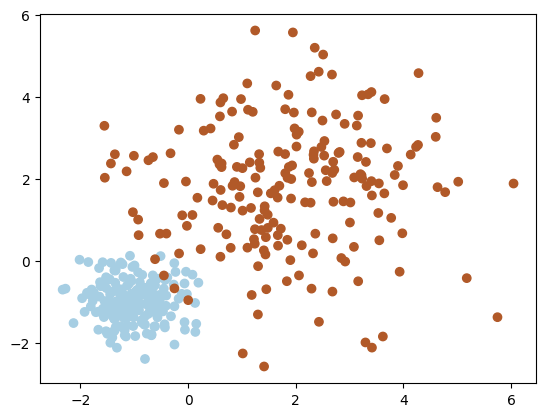

In [2]:
np.random.seed(0)
# Create toy dataset with 2 gaussians
y_true = np.hstack([
    np.zeros((200,)),
    np.ones((200,))
])

X = np.vstack([
    0.5 * np.random.randn(200, 2) - 1,  # Class 0 centered at (-1, -1).
    1.5 * np.random.randn(200, 2) + 2  # # Class 1 centered at (+2, +2).
])

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap=plt.cm.Paired)

We train this model on the toy dataset using the default parameters.

In [3]:
clf = sklearn.linear_model.Perceptron()
clf.fit(X, y_true)

Perceptron()

train error: 0.027500 


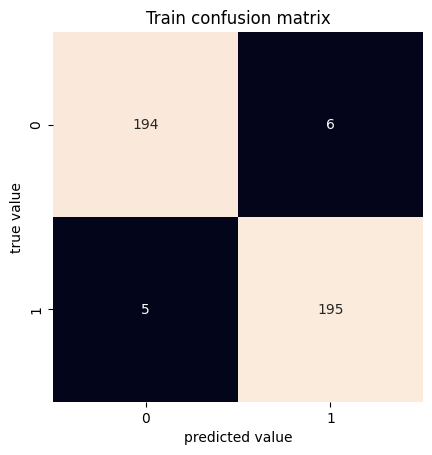

In [4]:
y_pred = clf.predict(X)
train_error = 1. - accuracy_score(y_true, y_pred)
train_cmat = confusion_matrix(y_true, y_pred)

print('train error: %f ' % train_error)
sns.heatmap(train_cmat, square=True, annot=True, cbar=False,fmt="d")
plt.title('Train confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()


We can plot the decision boundary between the two classes

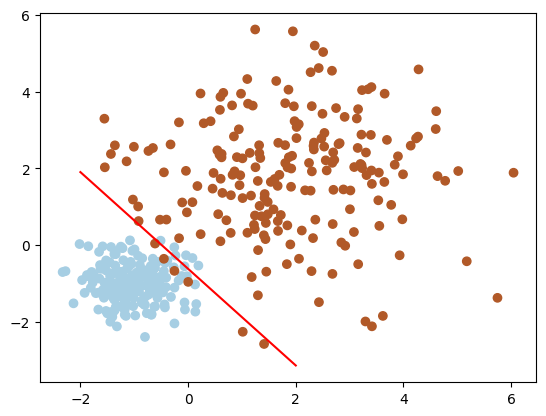

In [5]:
slope = - clf.coef_[0, 1] / clf.coef_[0, 0]
intercept = - clf.intercept_ / clf.coef_[0, 0]

plt.scatter(X[:, 0], X[:, 1], c=y_true,cmap=plt.cm.Paired)
plt.plot([-2, 2], [-2 * slope + intercept, 2 * slope + intercept ], "r")

### Non-Linearly separable classes
Now we will create a more difficult example.

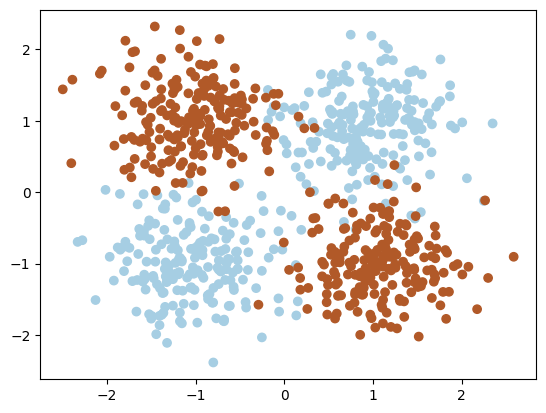

In [6]:
np.random.seed(0)
# Create toy dataset with 4 gaussians
y_true = np.hstack([
    np.zeros((200,)),
    np.zeros((200,)),
    np.ones((200,)),
    np.ones((200,))
])

X = np.vstack([
    0.5 * np.random.randn(200, 2) - 1,  # Class 0 centered at (-1, -1).
    0.5 * np.random.randn(200, 2) + 1,  # # Class 1 centered at (+2, +2).
    0.5 * np.random.randn(200, 2) + np.array([1, -1]),  # # Class 1 centered at (+2, +2).
    0.5 * np.random.randn(200, 2) + np.array([-1, 1])  # Class 0 centered at (-1, +1).
])

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y_true, zorder=10, cmap=plt.cm.Paired)

This problem can't be solved with a single perceptron:

In [7]:
clf = sklearn.linear_model.Perceptron()
clf.fit(X, y_true)

Perceptron()

train error: 0.552500 


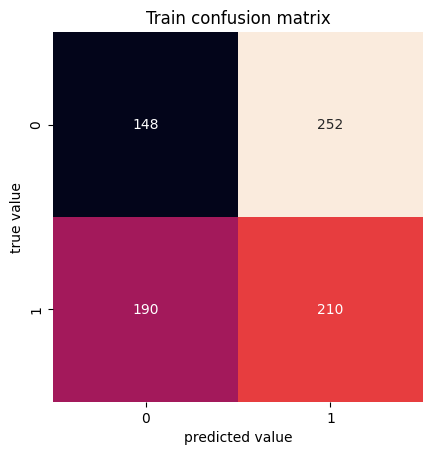

In [8]:
y_pred = clf.predict(X)
train_error = 1. - accuracy_score(y_true, y_pred)
train_cmat = confusion_matrix(y_true, y_pred)

print('train error: %f ' % train_error)
sns.heatmap(train_cmat, square=True, annot=True, cbar=False,fmt="d")
plt.title('Train confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()


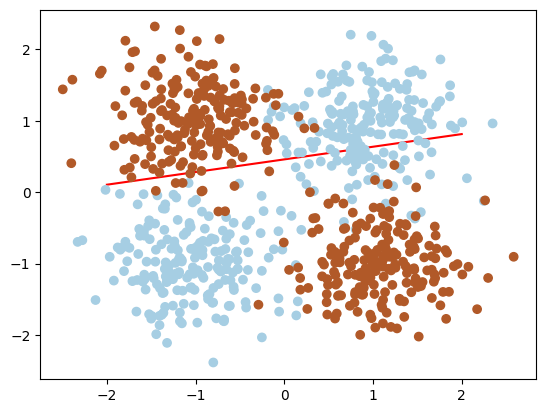

In [9]:
slope = - clf.coef_[0, 1] / clf.coef_[0, 0]
intercept = - clf.intercept_ / clf.coef_[0, 0]

plt.scatter(X[:, 0], X[:, 1], c=y_true, zorder=10, cmap=plt.cm.Paired)
plt.plot([-2, 2], [-2 * slope + intercept, 2 * slope + intercept ], "r")

### Adding an "interaction" feature
One way to solve a non-separable problem consists in adding some new features by combining the given ones, and trying to solve the problem with a linear classifyer on the new set of features.

We can use sklern.preprocessin.PolynomialFeatures, which generates polynomial and interaction features, as all polynomial combinations of the features with degree less than or equal to a specified degree (default degree=2).

In this example we only add the product of the two features (the 'interaction' feature x0*x1).

We create a pipeline with this preprocessing and the perceptron classifier

In [10]:
model = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.PolynomialFeatures(interaction_only=True),  # Add x0 * x1 as feature.
    clf
)
model.fit(X, y_true)

Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True)),
                ('perceptron', Perceptron())])

After fitting the model, we make the predictions and plot the decision regions and boundaries.

train error: 0.060000 


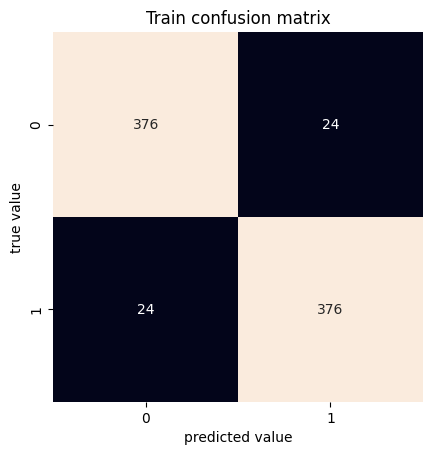

In [11]:
y_pred = model.predict(X)
train_error = 1. - accuracy_score(y_true, y_pred)
train_cmat = confusion_matrix(y_true, y_pred)

print('train error: %f ' % train_error)
sns.heatmap(train_cmat, square=True, annot=True, cbar=False,fmt="d")
plt.title('Train confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()

In [12]:
def plot_decision_regions(clf, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10,
                cmap=plt.cm.Paired, edgecolors='k')

    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)

    plt.contour(XX, YY, Z, colors=['k'], linestyles=['-'], levels=[0])

    # Put the result into a color plot
    plt.pcolormesh(XX, YY, Z, cmap=plt.cm.Paired)

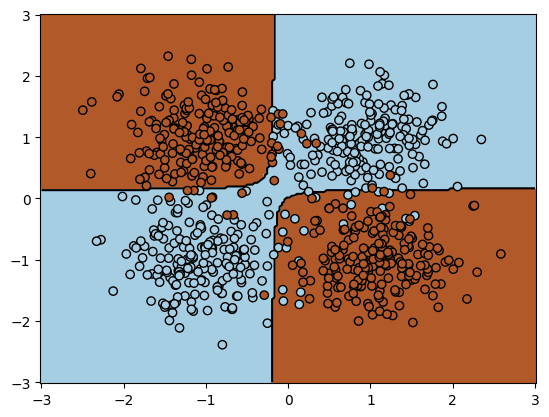

In [13]:
plot_decision_regions(model, X, y_true)

## Multi-layer perceptron
Now we will use a multi-layer perceptron to solve the same problem.
Multi-layer perceptrons "learn" different interaction variables to solve the problem.

We use scikit-learn class `MLPClassifier`, which implements a multi-layer perceptron (MLP) algorithm that is trained using some form of Gradient Descent with Backpropagation.
Note that this implementation is not intended for large-scale applications. In particular, scikit-learn offers no GPU support.

MLP trains on two arrays: array X of size `(n_samples, n_features)`, which holds the training samples represented as floating point feature vectors; and array y of size `(n_samples,)`, which holds the target values (class labels) for the training samples.

MLP can fit a non-linear model to the training data.  The model contanins the attributes `clf.coefs_` with the weight matrices that constitute the model parameters, and `intercepts_`, a list of bias vectors.

The MLPClassifier **supports only the Cross-Entropy loss function**, which allows probability estimates by running the `predict_proba` method.

MLP trains using some form of gradient descent and the gradients are calculated using Backpropagation. For classification, it minimizes the Cross-Entropy loss function, giving a vector of probability estimates $P(y|x)$ per sample $x$. MLPClassifier **supports multi-class classification by applying Softmax as the output function**. MLP trains using Stochastic Gradient Descent, Adam or L-BFGS (a quasi-Newton method not seen in class). See [Neural Network models](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) for more details.


For this problem let's train a MLP with a single hidden layer with 10 units, learning rate =0.001, relu activation, and stochastic gradient descent for a maximum of 500 iterations. The other parameters use the default values.

In [14]:
clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=500, learning_rate_init=0.01)
clf.fit(X, y_true)

MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=500,
              solver='sgd')

train error: 0.045000 


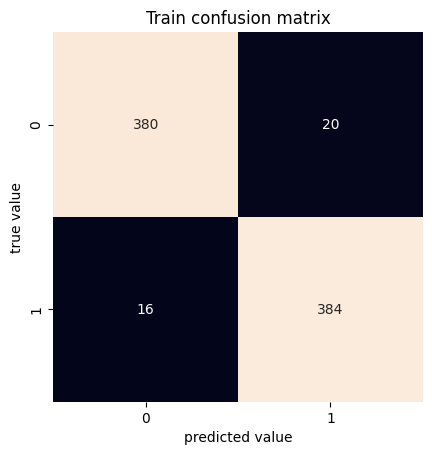

In [15]:
y_pred = clf.predict(X)
train_error = 1. - accuracy_score(y_true, y_pred)
train_cmat = confusion_matrix(y_true, y_pred)

print('train error: %f ' % train_error)
sns.heatmap(train_cmat, square=True, annot=True, cbar=False,fmt="d")
plt.title('Train confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()

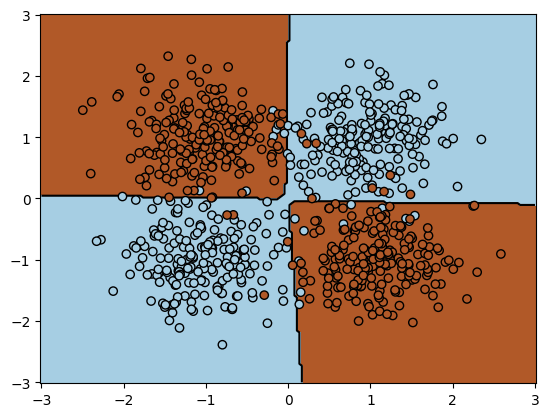

In [16]:
plot_decision_regions(clf, X, y_true)

We can look at the learned weights and biases, and print the final loss, best loss and plot the loss curve


In [17]:
# Check learned weights
print("Input to hidden layer")
print("    shape:", clf.coefs_[0].shape, clf.intercepts_[0].shape)
print("    weights: ", clf.coefs_[0])
print("    biases:  ", clf.intercepts_[0])
print("\nHidden layer to Output")
print("    shape:", clf.coefs_[1].shape, clf.intercepts_[1].shape)
print("    weights: ", clf.coefs_[1])
print("    biases:", clf.intercepts_[1])

Input to hidden layer
    shape: (2, 10) (10,)
    weights:  [[-0.14391799  0.76037185 -1.11163836 -0.36961371  1.31432522 -1.24247135
  -0.03763661  0.48953619 -1.69872244  1.40595028]
 [ 0.08549404  0.65753466  1.02858318  0.261914    1.44878816  1.13739764
  -0.12099758 -0.20861386 -1.52568393 -1.47225787]]
    biases:   [-0.42206469 -0.19637112 -0.02503621  0.07722602  0.16922607 -0.02592564
 -0.38074314 -0.21263247 -0.00865379 -0.04221879]

Hidden layer to Output
    shape: (10, 1) (1,)
    weights:  [[-0.68929199]
 [-0.66844257]
 [ 1.39917169]
 [ 0.19217511]
 [-1.9333431 ]
 [ 1.59622752]
 [ 0.21330654]
 [ 0.22096432]
 [-2.20853365]
 [ 2.0099978 ]]
    biases: [-0.00812085]


We can see the best score (accuracy), the minimum loss reached during training and plot the loss curve.

Note: with 10 neurons in the hidden layer, the algorithm stops before maxiter iterations (500), due to the n_iter_no_change parameter (maximum number of epochs to not meet tol improvement, default 10)

Training set score: 0.955000
Training set loss: 0.112939
Training set best loss: 0.112939


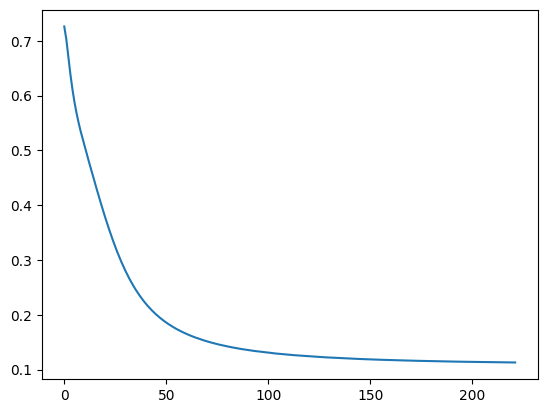

In [18]:
#Show last loss, best loss and loss curve
print("Training set score: %f" % clf.score(X, y_true))

print("Training set loss: %f" % clf.loss_)
print("Training set best loss: %f" % clf.best_loss_)

plt.plot(clf.loss_curve_)
plt.show()

#Part2: The MNIST classification problem

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. Note that the image is **represented on an inverted grayscale**: 0 represents white (background) and 255 represents black.

<img src = https://www.tensorflow.org/images/MNIST-Matrix.png height="200px">

## Data loading

We use Keras utility function to retrieve the MNIST dataset `mnist.load_data()`.

This function returns:
* x_train, x_test: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9) with shapes (num_samples,).


In [19]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Let's visualize the first 20 images in the training set (with 0 representing black and 255 white)

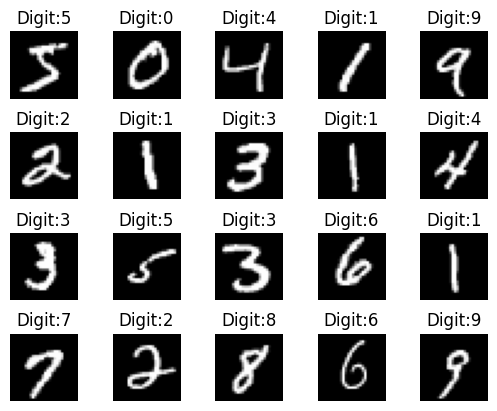

In [21]:
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_train[i],cmap='gray')
  plt.title("Digit:{}".format(y_train[i]))
  plt.subplots_adjust(hspace=0.5)
  plt.axis('off')

We will use a subset of the dataset, 15000 images for training and 2500 for test

In [22]:
X1_train = X_train[0:15000,:]
y1_train = y_train[0:15000]
X1_test = X_test[0:2500,:]
y1_test = y_test[0:2500]
print(X1_train.shape)
print(y1_train.shape)
print(X1_test.shape)
print(y1_test.shape)

(15000, 28, 28)
(15000,)
(2500, 28, 28)
(2500,)


Keras utility function to retrieve the MNIST dataset returns matrices of shape 28x28 as it is common for images, but scitkit-learn models expect data to be fed as vectors. In order to train our models them, we need to "reshape" our data.

In [23]:
X1_train = X1_train.reshape((-1, 28 * 28))
X1_test = X1_test.reshape((-1, 28 * 28))
print(X1_train.shape)
print(X1_test.shape)

(15000, 784)
(2500, 784)


Columns 1 through 784 contain the feature values, one per pixel for the 28×28=784 pixel values. The pixel values are on a gray scale in which 0 represents white, 255 represents black, and values between 0 and 255 represent shades of gray. Most of the pixel values are 0.

##The MLP Classifier

###Main parameters
**hidden_layer_sizes:** For this parameter you pass in a tuple consisting of the number of neurons at each layer, where the nth entry in the tuple represents the number of neurons in the nth layer
The ith element represents the number of neurons in the ith hidden layer.
> Example1: one hidden layer 100 neurons: (100,) (default)

> Example2: three hidden layers, 30 neurons each: (30,30,30)

**activation:** Activation function for the hidden layer. Options:‘identity’, ‘logistic’, ‘tanh’, ‘relu’(default).

**solver:**The solver for weight optimization. Options: lbfgs, sgd, adam (default).

**learning_rate_init:** The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’ (default=0.001)

**learning_rate:** Learning rate schedule for weight updates. Options: ‘constant’ (default), ‘invscaling’, ‘adaptive’

**momentum:** Momentum for gradient descent update('sgd'). Default 0.9.

**nesterovs_momentum:** Whether to use Nesterov’s momentum (if 'sgd', momentum>0).

**batch_size:** Size of minibatches for stochastic optimizers. If the solver is ‘lbfgs’, the classifier will not use minibatch. When set to “auto” (default), batch_size=min(200, n_samples)

**alpha:** L2 penalty (regularization term) parameter. Default=0.0001

###Attributes
**coefs_:** is a list of weight matrices, where weight matrix at index i represents the weights between layer i and layer i+1.

**intercepts_:** is a list of bias vectors, where the vector at index i represents the bias values added to layer i+1.

**loss_, best_loss_, loss_curve:** current loss, minimum loss, loss curve



##Training the MLP

We normalize the pixel values so they range between 0 and 1 using `MinMaxScaler`.

Take into account that extra preprocessing steps have been applied to this dataset, e.g. centering.

We create a pipeline to scale the data and apply the MLP classifier

In [24]:
model = sklearn.pipeline.Pipeline([
    ("scaling", sklearn.preprocessing.MinMaxScaler()),
    ("clf", sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(10,),solver='sgd',momentum=0))
])

In [25]:
model.fit(X1_train, y1_train)

Pipeline(steps=[('scaling', MinMaxScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(10,), momentum=0,
                               solver='sgd'))])

In [26]:
pred_train = model.predict(X1_train)
pred_test = model.predict(X1_test)

In [27]:
print("TRAINING\n" + classification_report(y1_train, pred_train))
print("\nTESTING\n" + classification_report(y1_test, pred_test))

TRAINING
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1496
           1       0.91      0.96      0.94      1690
           2       0.87      0.84      0.85      1462
           3       0.85      0.84      0.85      1548
           4       0.88      0.87      0.88      1468
           5       0.82      0.75      0.78      1318
           6       0.90      0.93      0.91      1490
           7       0.91      0.88      0.89      1593
           8       0.82      0.80      0.81      1432
           9       0.83      0.87      0.85      1503

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000


TESTING
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       219
           1       0.91      0.97      0.94       287
           2       0.87      0.79      0.83       276
      

train accuracy:  0.8728
train error:     0.12719999999999998
test accuracy:   0.8356
test error:      0.1644


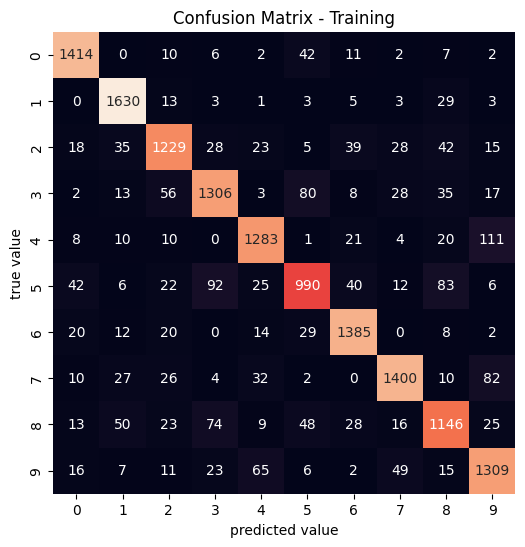

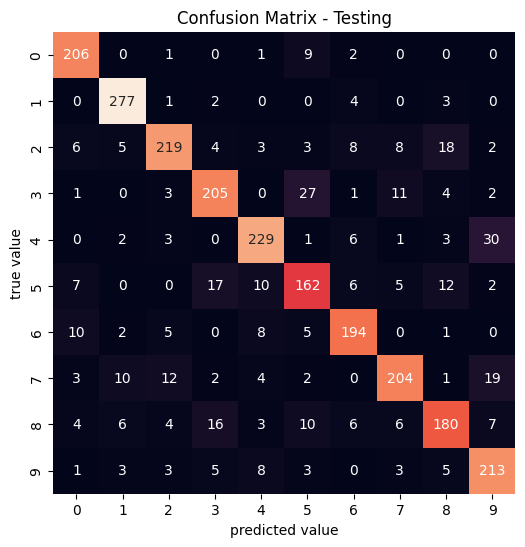

In [28]:
train_acc = accuracy_score(y1_train, pred_train)
train_cmat = confusion_matrix(y1_train, pred_train)
test_acc = accuracy_score(y1_test, pred_test)
test_cmat = confusion_matrix(y1_test, pred_test)
print('train accuracy: ', train_acc)
print('train error:    ', 1. - train_acc)
print('test accuracy:  ', test_acc)
print('test error:     ', 1. - test_acc)

plt.subplots(figsize=(6,6))
sns.heatmap(train_cmat, square=True, annot=True, cbar=False, fmt="d")
plt.title('Confusion Matrix - Training')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()

plt.subplots(figsize=(6,6))
sns.heatmap(test_cmat, square=True, annot=True, cbar=False, fmt="d")
plt.title('Confusion Matrix - Testing')
plt.xlabel('predicted value')
plt.ylabel('true value');
plt.show()

## Compare Stochastic learning strategies
Compare the learning strategies/solvers offered in the scikit-learn library: SGD (without or with momentum or nesterov_momentum), either with 'constant' or 'invscaling' learning rate schedules, and Adam optimization.

Plot the training loss vs the epoch across the learning
Use the loss_curve_ attribute from the trained model to obtain it



## Training MLP with Various Configurations
In this section, we train a Multilayer Perceptron (MLP) with the following configurations:
1. SGD, `'constant'`
2. SGD with momentum, `'constant'`
3. SGD with nesterov, `'constant'`
4. SGD, `'invscaling'`
5. SGD with momentum, `'invscaling'`
6. SGD with nesterov, `'invscaling'`
7. Adam

We evaluate the models based on their training set scores and plot all loss curves.

In [29]:
# Plot the training loss vs the epoch across the learning
# Use the loss_curve_ attribute from the trained model to obtain it

# your code here

configurations = [
    {"solver": 'sgd', "momentum": 0, "nesterovs_momentum": False, "learning_rate": 'constant', "label": "SGD, constant"},
    {"solver": 'sgd', "momentum": 0.9, "nesterovs_momentum": False, "learning_rate": 'constant', "label": "SGD with momentum, constant"},
    {"solver": 'sgd', "momentum": 0.9, "nesterovs_momentum": True, "learning_rate": 'constant', "label": "SGD with nesterov, constant"},
    {"solver": 'sgd', "momentum": 0, "nesterovs_momentum": False, "learning_rate": 'invscaling', "label": "SGD, invscaling"},
    {"solver": 'sgd', "momentum": 0.9, "nesterovs_momentum": False, "learning_rate": 'invscaling', "label": "SGD with momentum, invscaling"},
    {"solver": 'sgd', "momentum": 0.9, "nesterovs_momentum": True, "learning_rate": 'invscaling', "label": "SGD with nesterov, invscaling"},
    {"solver": 'adam', "label": "Adam"}
]
scores = []
loss_curves = []
final_losses = []

for config in configurations:
    print(f"Training with configuration: {config['label']}")
    clf = MLPClassifier(
        hidden_layer_sizes=(10,),
        solver=config["solver"],
        momentum=config.get("momentum", 0),
        nesterovs_momentum=config.get("nesterovs_momentum", False),
        learning_rate=config.get("learning_rate", 'constant'),
        max_iter=200,
        random_state=42
    )
    clf.fit(X1_train, y1_train)

    # Store training score, loss curve, and final loss
    scores.append((config['label'], clf.score(X1_train, y1_train)))
    loss_curves.append((config['label'], clf.loss_curve_))
    final_losses.append((config['label'], clf.loss_curve_[-1]))

# Print final training set scores and loss values
print("\nFinal Training Set Scores and Loss Values:")
print(f"{'Configuration':<40} {'Score':<10} {'Final Loss':<10}")
print("-" * 60)
for (label, score), (_, final_loss) in zip(scores, final_losses):
    print(f"{label:<40} {score:.4f}     {final_loss:.4f}")



Training with configuration: SGD, constant
Training with configuration: SGD with momentum, constant
Training with configuration: SGD with nesterov, constant
Training with configuration: SGD, invscaling
Training with configuration: SGD with momentum, invscaling
Training with configuration: SGD with nesterov, invscaling
Training with configuration: Adam

Final Training Set Scores and Loss Values:
Configuration                            Score      Final Loss
------------------------------------------------------------
SGD, constant                            0.1940     2.0515
SGD with momentum, constant              0.1127     2.3008
SGD with nesterov, constant              0.1127     2.3008
SGD, invscaling                          0.0999     2.3924
SGD with momentum, invscaling            0.0997     2.3687
SGD with nesterov, invscaling            0.0997     2.3686
Adam                                     0.8797     0.4059


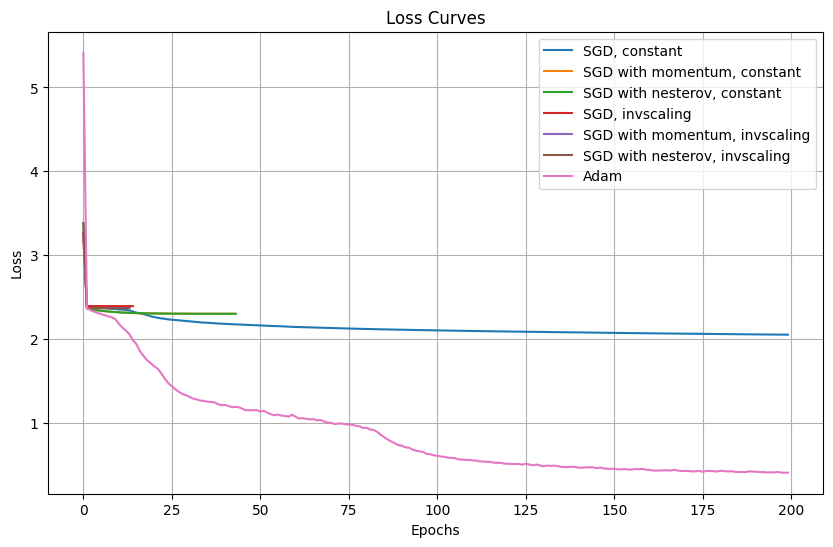

In [30]:
# Plot all loss curves
plt.figure(figsize=(10, 6))
for label, loss_curve in loss_curves:
    plt.plot(loss_curve, label=label)

plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

# 5


## Hyper-parameter search
Try a range of values for our model's hyper-parameters and evaluate the performance on a validation set.
As we have seen on previous practices, scikit-learn provides functionalities for this purposes (use a `ShuffleSplit` with `n_splits=1` to avoid doing cross-validation as it would take too much time).

This is an example of parameter choices (you should look into the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to know its meaning), but feel free to try other combinations and more or less values per hyperparameter, or other values:
```
hidden_layer_sizes = [(100,), (100, 100)]
activation = ["logistic", "relu"]
alpha = [0.0001, 0.001]
batch_size = ["auto", 16]
learning_rate = ["constant", "adaptive"]
learning_rate_init = [0.001, 0.01]
```

1. First, create a new pipeline and name it `model2`. In this pipeline, apply a preprocesing with MinMaxScaler and then the MLP classifier. Note that you can use the parameter max_iter in the MLPClassifier to limit the number of epochs (for example max_iter=100) (see documentation)

2. Then, define the values for hyperparameter grid search (uncomment or change the proposed values)

3. Add the code to performe a GridSearchCV on `model2`, using ShuffleSplit with n_splits=1,
and a training subset with the 75% of the taining set (X1).




In [31]:
#pipeline
model2 = Pipeline([
    ("scaling", MinMaxScaler()),
    ("clf", MLPClassifier(max_iter=100))
])

#param grid
param_grid = {
    "clf__hidden_layer_sizes": [(100,), (100, 100)],
    "clf__activation": ["logistic", "relu"],
    "clf__alpha": [0.0001, 0.001],
    "clf__batch_size": ["auto", 16],
    "clf__learning_rate": ["constant", "adaptive"],
    "clf__learning_rate_init": [0.001, 0.01]
}

#ShuffleSplit
cv = ShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

#GridSearchCV
grid_search = GridSearchCV(model2, param_grid, cv=cv, scoring="accuracy", verbose=1, n_jobs=-1)
grid_search.fit(X1_train, y1_train)

best_model = grid_search.best_estimator_
print("Best parameters found:")
print(grid_search.best_params_)


Fitting 1 folds for each of 64 candidates, totalling 64 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

Best parameters found:
{'clf__activation': 'relu', 'clf__alpha': 0.0001, 'clf__batch_size': 16, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'adaptive', 'clf__learning_rate_init': 0.001}


After the model is trained, you can easily inspect the results by converting the `GridSearchCV` results dictionary into a `DataFrame`.

In [32]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__activation,param_clf__alpha,param_clf__batch_size,param_clf__hidden_layer_sizes,param_clf__learning_rate,param_clf__learning_rate_init,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,44.387691,0.0,0.074209,0.0,logistic,0.0001,auto,"(100,)",constant,0.001,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.954400,0.954400,0.0,45
1,22.109091,0.0,0.075526,0.0,logistic,0.0001,auto,"(100,)",constant,0.01,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.956533,0.956533,0.0,38
2,45.457329,0.0,0.073077,0.0,logistic,0.0001,auto,"(100,)",adaptive,0.001,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.954400,0.954400,0.0,45
3,22.159679,0.0,0.074054,0.0,logistic,0.0001,auto,"(100,)",adaptive,0.01,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.957867,0.957867,0.0,34
4,55.113488,0.0,0.089416,0.0,logistic,0.0001,auto,"(100, 100)",constant,0.001,"{'clf__activation': 'logistic', 'clf__alpha': ...",0.957067,0.957067,0.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,71.133802,0.0,0.305933,0.0,relu,0.001,16,"(100,)",adaptive,0.01,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.942933,0.942933,0.0,62
60,127.772558,0.0,0.099591,0.0,relu,0.001,16,"(100, 100)",constant,0.001,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.959200,0.959200,0.0,27
61,205.292087,0.0,0.112770,0.0,relu,0.001,16,"(100, 100)",constant,0.01,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.951733,0.951733,0.0,55
62,68.108261,0.0,0.064129,0.0,relu,0.001,16,"(100, 100)",adaptive,0.001,"{'clf__activation': 'relu', 'clf__alpha': 0.00...",0.953067,0.953067,0.0,53


# 6

## Test results

Add the code to make the predictions ont the X1_train and X1_test sets
Show the classification report, confusion matrices, global accuracy and error for training and test sets

In [33]:
# Evaluate on the training set
pred_train = best_model.predict(X1_train)
print("TRAINING\n" + classification_report(y1_train, pred_train))
train_acc = accuracy_score(y1_train, pred_train)
train_cmat = confusion_matrix(y1_train, pred_train)

# Evaluate on the test set
pred_test = best_model.predict(X1_test)
print("\nTESTING\n" + classification_report(y1_test, pred_test))
test_acc = accuracy_score(y1_test, pred_test)
test_cmat = confusion_matrix(y1_test, pred_test)

print('Train accuracy: ', train_acc)
print('Train error:    ', 1. - train_acc)
print('Test accuracy:  ', test_acc)
print('Test error:     ', 1. - test_acc)

TRAINING
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1496
           1       1.00      1.00      1.00      1690
           2       1.00      1.00      1.00      1462
           3       1.00      1.00      1.00      1548
           4       1.00      1.00      1.00      1468
           5       1.00      1.00      1.00      1318
           6       1.00      1.00      1.00      1490
           7       1.00      1.00      1.00      1593
           8       1.00      1.00      1.00      1432
           9       1.00      1.00      1.00      1503

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000


TESTING
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       219
           1       0.97      0.98      0.97       287
           2       0.96      0.95      0.95       276
      

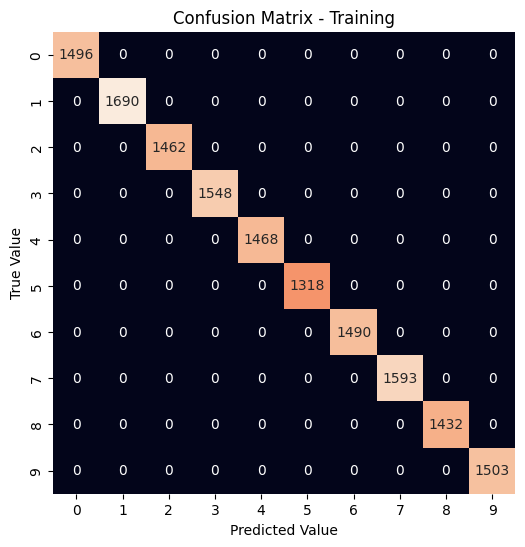

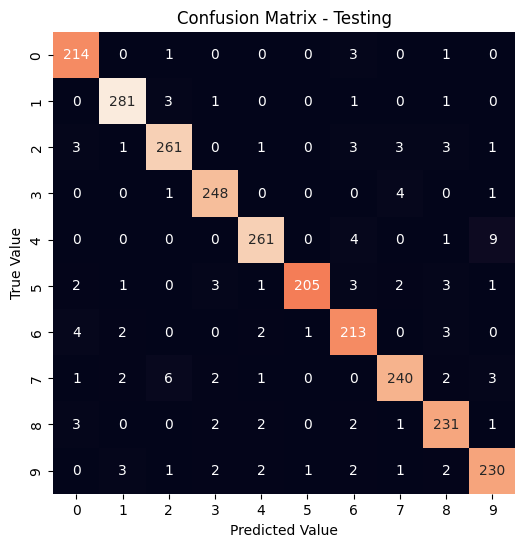

In [34]:
# Plot the confusion matrices
plt.subplots(figsize=(6, 6))
sns.heatmap(train_cmat, square=True, annot=True, cbar=False, fmt="d")
plt.title('Confusion Matrix - Training')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()

plt.subplots(figsize=(6, 6))
sns.heatmap(test_cmat, square=True, annot=True, cbar=False, fmt="d")
plt.title('Confusion Matrix - Testing')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.show()